In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np

vantage1 = pd.read_csv('/content/drive/My Drive/VantageAgora/Sample1.CSV', encoding = "ISO-8859-1")
vantage2 = pd.read_csv('/content/drive/My Drive/VantageAgora/Sample2.CSV', encoding = "ISO-8859-1")

print(vantage1.shape)
print(vantage2.shape)

#print(vantage1.describe())
#print(vantage2.describe())

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,7,32,33,42,63,66,72,76,128,134,135) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(12417, 147)
(44643, 146)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,7,20,32,33,63,91,125,126,127,128,130,133,136,139,145) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We can actually reduce it to the columns that are useful for prediction, and make sure to leave out the ones we found to be null earlier. We have retained some columns that are not predictive/predictable but provide identifying information.

In [0]:
useful_cols1 = ['CLMNO', 'OCCURRENCE', 'CLNTNO', 'NET_INDEMNITY_RESERVE', 'NET_EXPENSE_RESERVE', 'CARRIERCLMNO', 'CLIENTSCLMNO', 'LOSSDATE', 'STATUS', 'OPENDATE', 'CLOSEDATE', 'REOPENDATE', 'LOB', 'COVERAGE', 'STATE', 'DESCR', 'DESCR2', 'INJURIES', 'IPOLNO', 'IEFFDT', 'IEXPDT', 'CCITY', 'CSTATE',  'CGENDER', 'LOCDESC', 'LOC', 'LOCNM', 'LOCCITY', 'LOCSTATE', 'LOCZIP', 'VINNO', 'AUTOMAKE', 'VEHYEAR', 'DRIVERAGE', 'LICSTATE', 'DOB', 'INDRESERVES', 'MEDRESERVES', 'EXPRESERVES', 'TOTALRESERVES', 'INDPAID', 'MEDPAID', 'EXPPAID', 'YORKPAID', 'TOTALPAID', 'RECOVERIES', 'INCURRED', 'AWM_Cause_Code', 'Deductible']
#the second set includes the non-null CAUSE column and does not include Deductible (that column does not exist in the second dataset)
useful_cols2 = ['CLMNO', 'OCCURRENCE', 'CLNTNO', 'NET_INDEMNITY_RESERVE', 'NET_EXPENSE_RESERVE', 'CARRIERCLMNO', 'CLIENTSCLMNO', 'LOSSDATE', 'STATUS', 'OPENDATE', 'CLOSEDATE', 'REOPENDATE', 'LOB', 'COVERAGE', 'STATE', 'DESCR', 'DESCR2', 'INJURIES', 'IPOLNO', 'IEFFDT', 'IEXPDT', 'CCITY', 'CSTATE',  'CGENDER', 'LOCDESC', 'LOC', 'LOCNM', 'LOCCITY', 'LOCSTATE', 'LOCZIP', 'VINNO', 'AUTOMAKE', 'VEHYEAR', 'DRIVERAGE', 'LICSTATE', 'DOB', 'INDRESERVES', 'MEDRESERVES', 'EXPRESERVES', 'TOTALRESERVES', 'INDPAID', 'MEDPAID', 'EXPPAID', 'YORKPAID', 'TOTALPAID', 'RECOVERIES', 'INCURRED', 'AWM_Cause_Code', 'CAUSE']

In [0]:
vantage1 = vantage1[useful_cols1]
vantage2 = vantage2[useful_cols2]

Now we check for duplicates and remove them, keeping only the first occurrence.

In [0]:
vantage1.drop_duplicates(keep='first', inplace=True)
vantage2.drop_duplicates(keep='first', inplace=True)

Now we check how sparse our columns are and plot their distributions. We will first focus on the larger dataset, vantage2.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


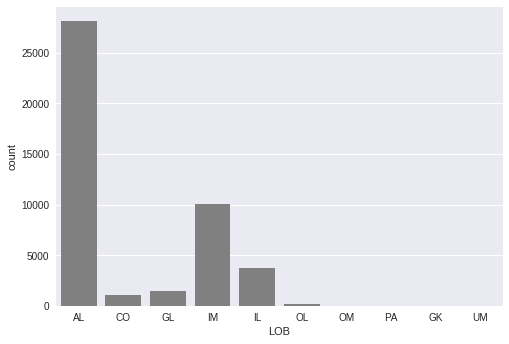

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.countplot(vantage2['LOB'], color='gray')

As we are focusing on cars and drivers, we need only AL (automobile liability) data.

In [0]:
vantage2 = vantage2[vantage2['LOB'] == 'AL']

Now we will look at LOSSDATE, OPENDATE and CLOSEDATE to see when claims are most likely to be made, and how long they tend to last.

In [0]:
vantage2['LOSSDATE'] = pd.to_datetime(vantage2['LOSSDATE'], format='%Y%m%d')
vantage2['LOSSDATE'][:10]

0    2012-06-11
1    2012-06-15
2    2012-06-15
3    2012-06-13
4    2012-06-11
5    2012-04-02
6    2012-06-06
7    2012-06-08
8    2012-06-14
10   2012-06-18
Name: LOSSDATE, dtype: datetime64[ns]

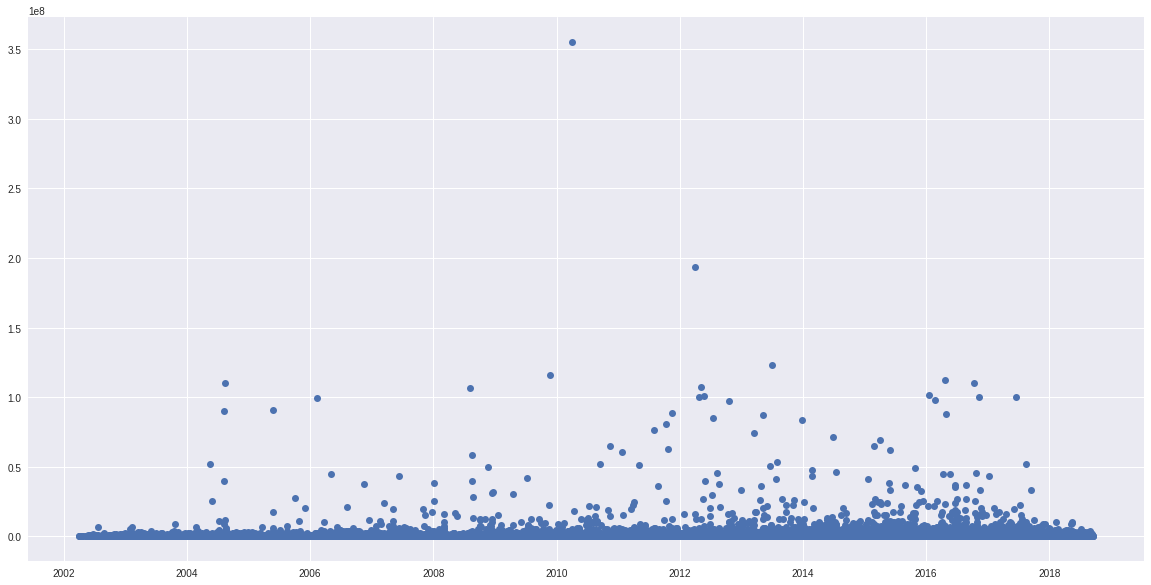

In [0]:
import matplotlib.dates as matdate
plt.figure(figsize=(20,10))
list_of_dates = list(vantage2['LOSSDATE'])
dates = matdate.date2num(list_of_dates)
values = list(vantage2['INCURRED'])
plt.plot_date(dates, values)

Overall, the number of claims seems to be increasing from 2002 to 2017 or so. However, we see that most of the claims are lower than $20 million. So we should plot another graph without the outliers.

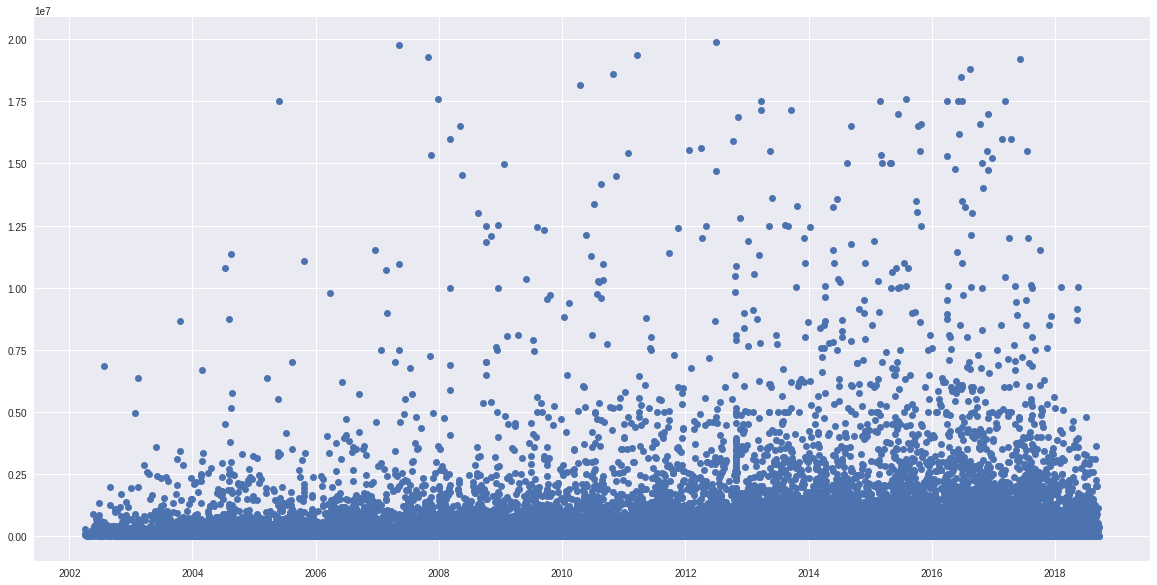

In [0]:
newdates = []
newvalues = []
plt.figure(figsize=(20,10))

for i in range(len(values)):
  if values[i] < 20000000:
    newvalues.append(values[i])
    newdates.append(dates[i])

plt.plot_date(newdates, newvalues)

Now to check even lower values, with a threshold of $5 million:

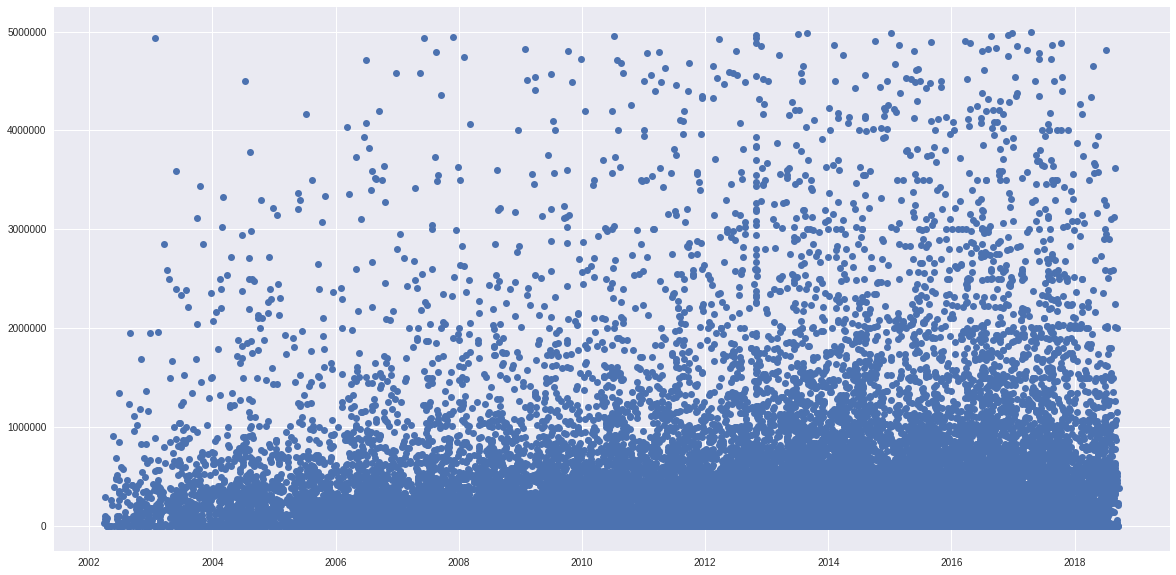

In [0]:
newdates = []
newvalues = []
plt.figure(figsize=(20,10))

for i in range(len(values)):
  if values[i] < 5000000:
    newvalues.append(values[i])
    newdates.append(dates[i])

plt.plot_date(newdates, newvalues)

And now for sub-$1 million claims:

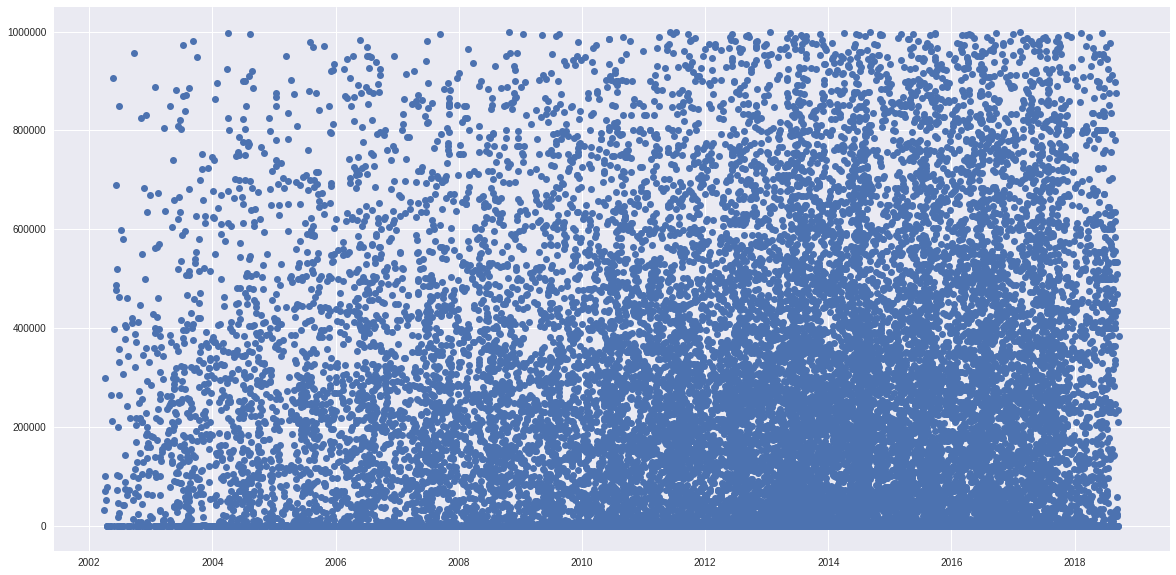

In [0]:
newdates = []
newvalues = []
plt.figure(figsize=(20,10))

for i in range(len(values)):
  if values[i] < 1000000:
    newvalues.append(values[i])
    newdates.append(dates[i])

plt.plot_date(newdates, newvalues)

In [0]:
dates[:10]

Now we get monthwise data - mean, median and count

In [0]:
data = {'LOSSDATE': list_of_dates, 'INCURRED': values}
frame = pd.DataFrame(data)
frame.set_index('LOSSDATE',inplace=True)
mean_month = frame.resample('M',how='mean')
median_month = frame.resample('M',how='median')
count_month = frame.resample('M',how={'INCURRED':'count'})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).median()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)



In [0]:
print(mean_month.describe())
print(median_month.describe())
print(count_month.describe())

           INCURRED
count  1.980000e+02
mean   7.373130e+05
std    5.526488e+05
min    7.068411e+04
25%    4.559978e+05
50%    6.155298e+05
75%    8.412687e+05
max    4.648015e+06
            INCURRED
count     198.000000
mean   212180.136364
std     59909.147562
min     35100.000000
25%    183429.500000
50%    207967.000000
75%    240199.125000
max    491981.500000
         INCURRED
count  198.000000
mean   142.151515
std     92.616546
min      7.000000
25%     61.250000
50%    121.000000
75%    215.750000
max    398.000000


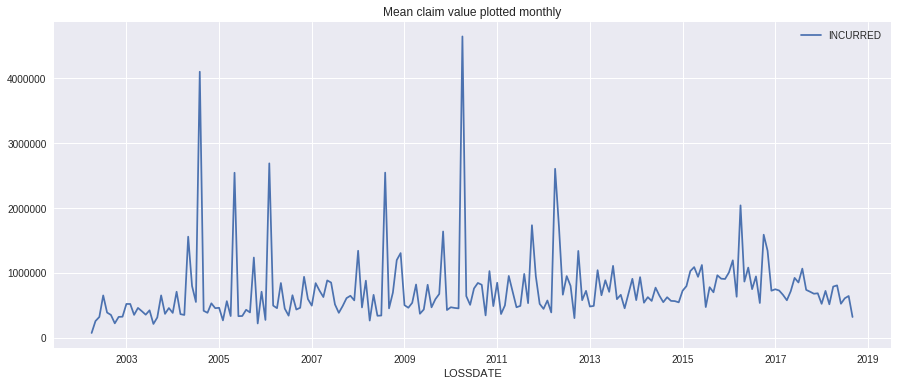

In [0]:
mean_month.plot(figsize=(15, 6))
plt.title("Mean claim value plotted monthly")
plt.show()

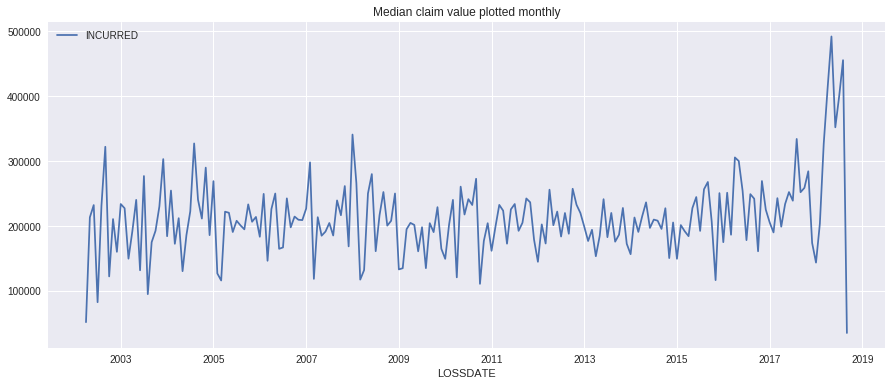

In [0]:
median_month.plot(figsize=(15, 6))
plt.title("Median claim value plotted monthly")
plt.show()

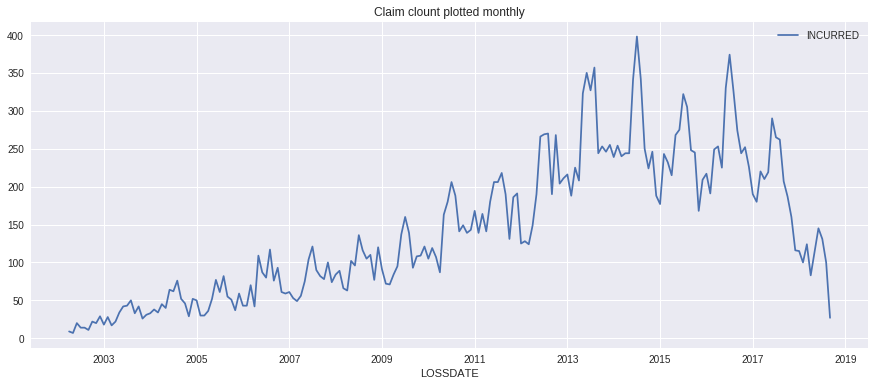

In [0]:
count_month.plot(figsize=(15, 6))
plt.title("Claim clount plotted monthly")
plt.show()

Now we choose the claims 2016 onward. We will find the mean and median claim values every month, and also the count of claims every month 

In [0]:
frame_2016 = frame['2016':]
mean_month_2016 = frame_2016.resample('M',how='mean')
median_month_2016 = frame_2016.resample('M',how='median')
count_month_2016 = frame_2016.resample('M',how={'INCURRED':'count'})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).median()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)



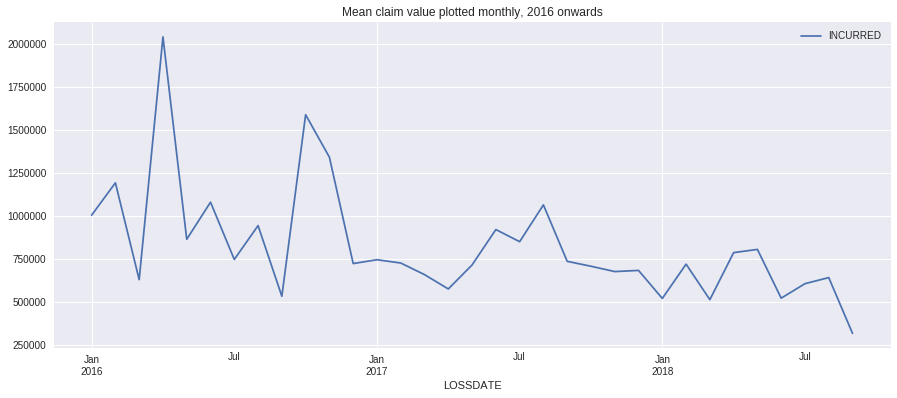

In [0]:
mean_month_2016.plot(figsize=(15, 6))
plt.title("Mean claim value plotted monthly, 2016 onwards")
plt.show()

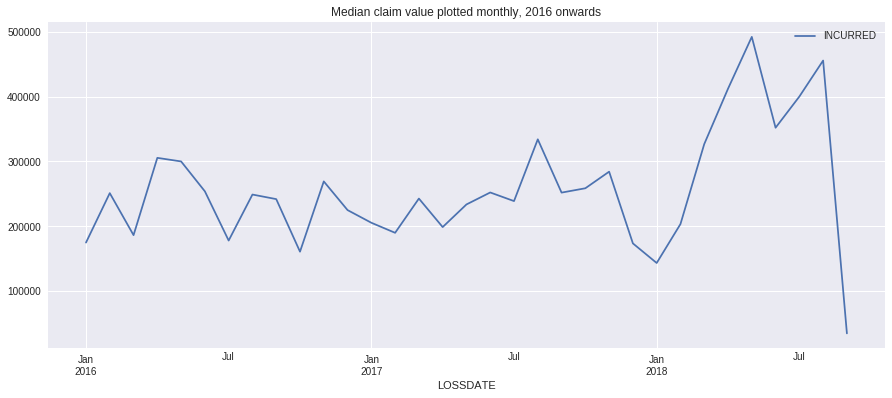

In [0]:
median_month_2016.plot(figsize=(15, 6))
plt.title("Median claim value plotted monthly, 2016 onwards")
plt.show()

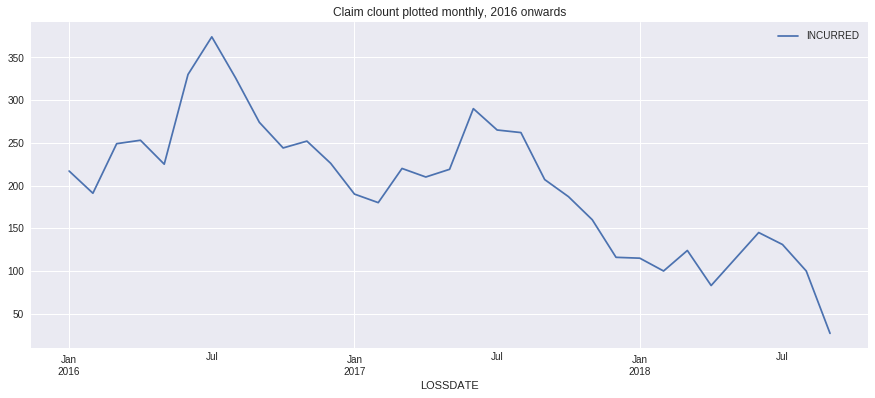

In [0]:
count_month_2016.plot(figsize=(15, 6))
plt.title("Claim clount plotted monthly, 2016 onwards")
plt.show()

April and May had the largest median claim values in 2016. July had the highest claim count, but its median claim value was one of the lowest

For more granularity, let us take claims week by week

In [0]:
frame_2016 = frame['2016':]
mean_week_2016 = frame_2016.resample('W',how='mean')
median_week_2016 = frame_2016.resample('W',how='median')
count_week_2016 = frame_2016.resample('W',how={'INCURRED':'count'})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).median()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)



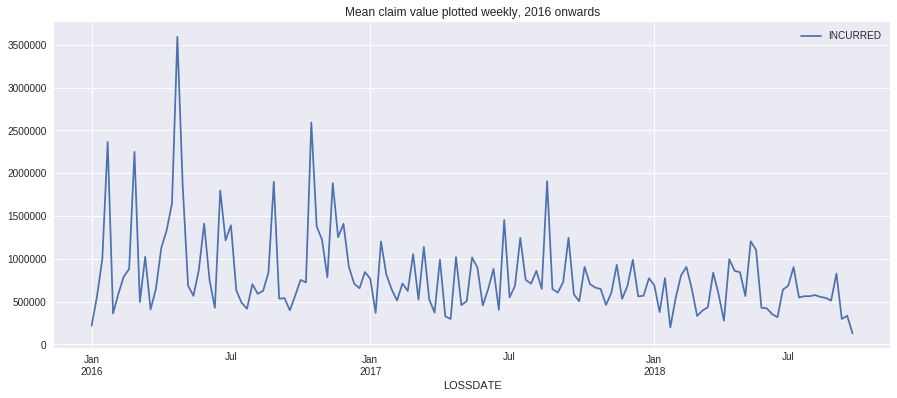

In [0]:
mean_week_2016.plot(figsize=(15, 6))
plt.title("Mean claim value plotted weekly, 2016 onwards")
plt.show()

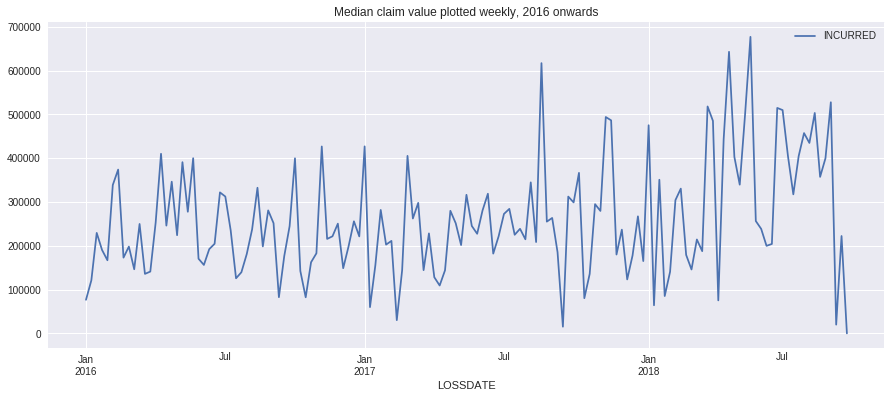

In [0]:
median_week_2016.plot(figsize=(15, 6))
plt.title("Median claim value plotted weekly, 2016 onwards")
plt.show()

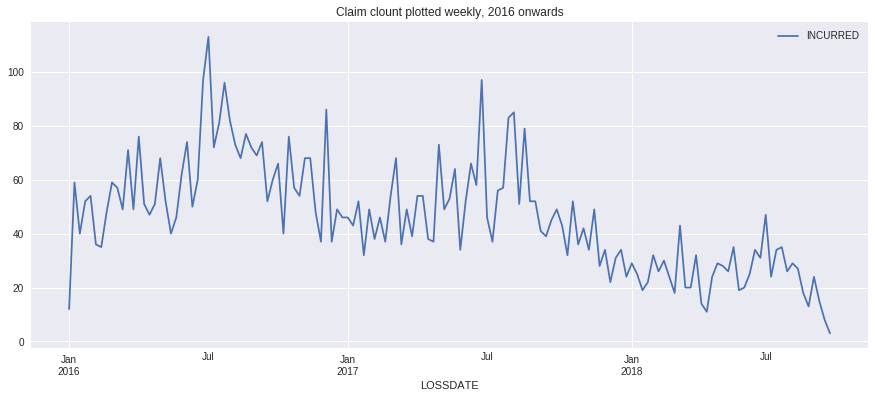

In [0]:
count_week_2016.plot(figsize=(15, 6))
plt.title("Claim clount plotted weekly, 2016 onwards")
plt.show()

Now we look at the claim counts trend since 2016 and decompose it:

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



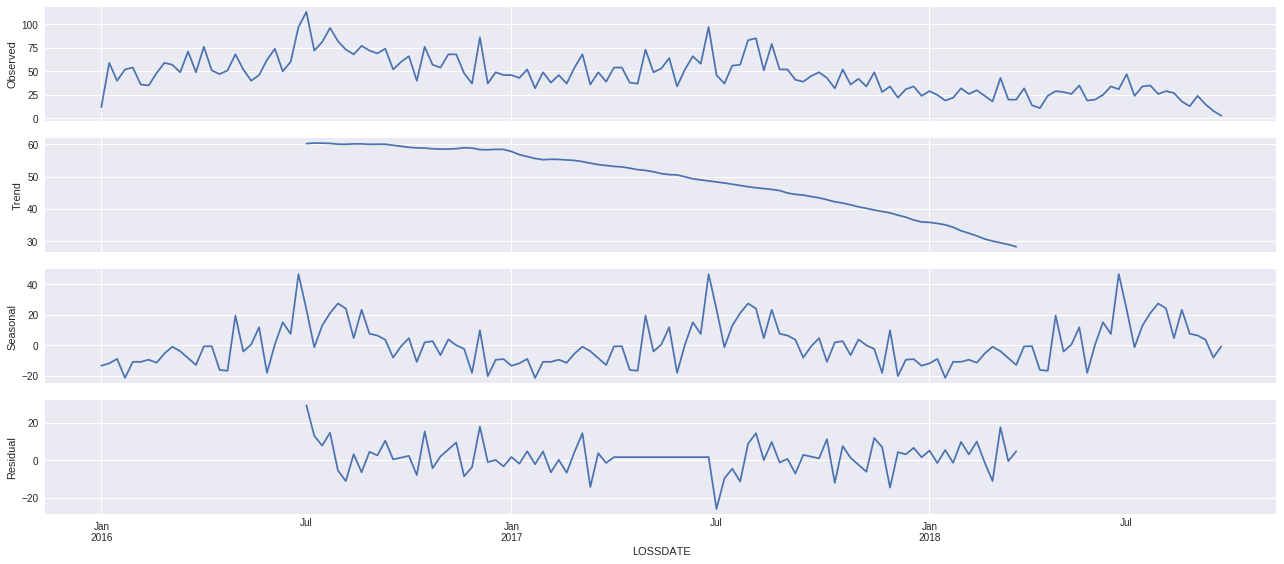

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(count_week_2016, model='additive')
fig = decomposition.plot()
plt.show()

If we look at seasonality, there is always a spike around July, and a smaller one right after around August. People are generally more reckless in summer, and they are less likely to take precautions in good weather. There is also a lot more traffic during those vacation months.

Now we look at the ARIMA method for time series forecasting.

In [0]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
#52 for 52 weeks

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 0, 0, 52)


In [0]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(count_week_2016,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                                                                                                                                                                         
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(1, 0, 0, 52)12 - AIC:775.3428821177707
ARIMA(0, 0, 0)x(1, 1, 0, 52)12 - AIC:383.60137025205654
ARIMA(0, 0, 1)x(0, 0, 0, 52)12 - AIC:1387.6398901078842
ARIMA(0, 0, 1)x(0, 1, 0, 52)12 - AIC:818.3060932470406
ARIMA(0, 0, 1)x(1, 0, 0, 52)12 - AIC:770.714127440739
ARIMA(0, 0, 1)x(1, 1, 0, 52)12 - AIC:369.8120425243026
ARIMA(0, 1, 0)x(1, 0, 0, 52)12 - AIC:748.7271055847199
ARIMA(0, 1, 0)x(1, 1, 0, 52)12 - AIC:327.45284751746834
ARIMA(0, 1, 1)x(0, 0, 0, 52)12 - AIC:1125.8424618541567
ARIMA(0, 1, 1)x(0, 1, 0, 52)12 - AIC:754.4393383068012
ARIMA(0, 1, 1)x(1, 0, 0, 52)12 - AIC:707.1765169549606
ARIMA(0, 1, 1)x(1, 1, 0, 52)12 - AIC:308.8336293922003
ARIMA(1, 0, 0)x(0, 0, 0, 52)12 - AIC:1207.4095971302622
ARIMA(1, 0, 0)x(0, 1, 0, 52)12 - AIC:810.9756822674788
ARIMA(1, 0, 0)x(1, 0, 0, 52)12 - AIC:746.3103000346006
ARIMA(1, 0, 0)x(1, 1, 0, 52)12 - AIC:328.2482168170316
ARIMA(1, 0, 1)x(0, 0, 0, 52)12 - AIC:1135.6445094536425


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(0, 1, 0, 52)12 - AIC:759.0441116057468
ARIMA(1, 0, 1)x(1, 0, 0, 52)12 - AIC:707.4882210048546
ARIMA(1, 0, 1)x(1, 1, 0, 52)12 - AIC:305.3161111359798
ARIMA(1, 1, 0)x(0, 0, 0, 52)12 - AIC:1159.760126350916
ARIMA(1, 1, 0)x(0, 1, 0, 52)12 - AIC:790.0378922075324
ARIMA(1, 1, 0)x(1, 0, 0, 52)12 - AIC:716.1236544623338
ARIMA(1, 1, 0)x(1, 1, 0, 52)12 - AIC:309.92423526678823
ARIMA(1, 1, 1)x(0, 0, 0, 52)12 - AIC:1127.45050923925
ARIMA(1, 1, 1)x(0, 1, 0, 52)12 - AIC:756.0405444719512
ARIMA(1, 1, 1)x(1, 0, 0, 52)12 - AIC:701.159030763355
ARIMA(1, 1, 1)x(1, 1, 0, 52)12 - AIC:301.00566099677263


ARIMA(1, 1, 1)x(1, 1, 0, 52)12 - AIC:301.00566099677263 has the lowest AIC value, so we will use it 

In [0]:
mod = sm.tsa.statespace.SARIMAX(count_week_2016,order=(1, 1, 1),seasonal_order=(1, 1, 0, 52),enforce_stationarity=False,enforce_invertibility=False)
                                                                                                                               
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1799      0.202     -0.891      0.373      -0.575       0.216
ma.L1         -0.7335      0.164     -4.461      0.000      -1.056      -0.411
ar.S.L52      -0.5599      0.144     -3.880      0.000      -0.843      -0.277
sigma2       159.0976     38.081      4.178      0.000      84.460     233.735


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



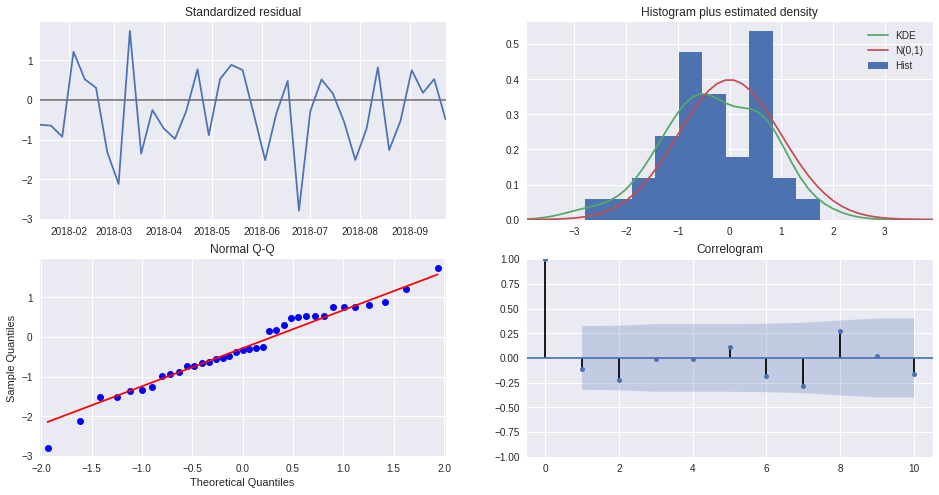

In [0]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

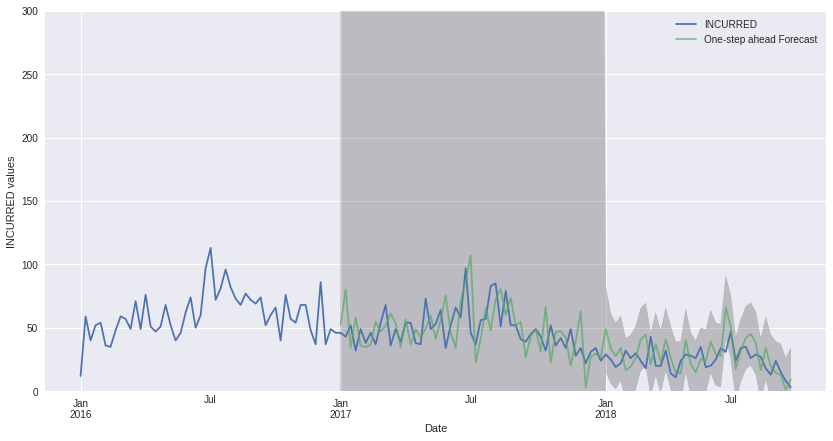

In [0]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = count_week_2016['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)
                
                

ax.set_xlabel('Date')
ax.set_ylabel('INCURRED values')
plt.legend()
plt.axis([None,None,0,300])
plt.show()

In [0]:
y_forecasted = pred.predicted_mean
y_truth = count_week_2016['2017':]

print(len(y_forecasted))
print(len(y_truth))
#print(y_forecasted[0])
#print(y_truth['INCURRED'][0])
y_forecasted = np.array(y_forecasted)
y_truth = np.array(y_truth['INCURRED'])

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

me = (y_forecasted - y_truth).mean()
print('The Mean Absolute Error of our forecasts is {}'.format(round(me, 2)))

91
91
The Mean Squared Error of our forecasts is 296.99
The Mean Absolute Error of our forecasts is 2.23


Hence the error rate for ARIMA prediction of weekly claim counts is very low. To predict using ARIMA:

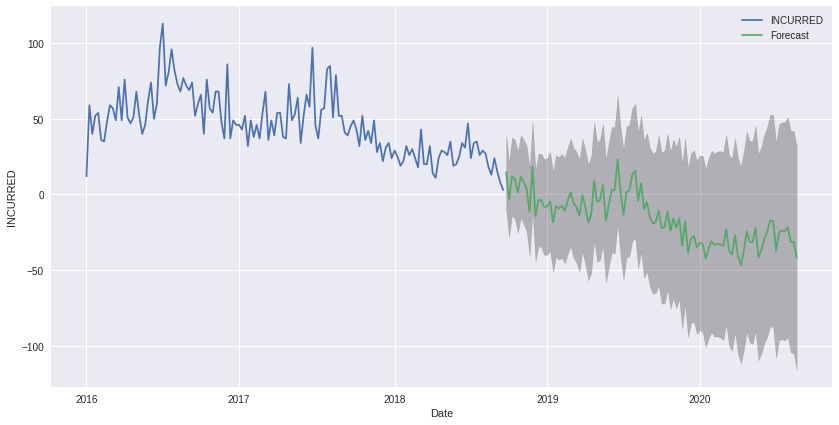

In [0]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = count_week_2016.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
                               
ax.set_xlabel('Date')
ax.set_ylabel('INCURRED')

plt.legend()
plt.show()

Now we will check if the INCURRED value has any correlation with the number of days it takes for the claim to be settled.

In [0]:
vantage2['OPENDATE'] = pd.to_datetime(vantage2['OPENDATE'], format='%Y%m%d')

In [0]:
vantage2['CLOSEDATE'] = pd.to_datetime(vantage2['CLOSEDATE'], format='%Y%m%d')
vantage2['CLOSEDATE'][:25]

0    2013-07-03
1    2013-08-09
2    2013-08-09
3    2012-06-22
4    2012-09-24
5    2012-07-27
6    2012-07-03
7    2012-07-20
8    2012-07-10
10   2012-06-21
11   2014-05-21
12   2013-02-01
13   2014-06-30
14   2014-05-21
15   2014-06-30
16   2012-08-02
17   2012-10-09
18   2013-05-09
19   2013-01-30
20          NaT
21   2012-08-07
22   2012-10-12
23   2012-07-13
25   2012-04-17
26   2012-03-28
Name: CLOSEDATE, dtype: datetime64[ns]

In [0]:
vantage_time = vantage2.dropna(axis=0, subset=['CLOSEDATE'])
claim_lengths = [abs(int(i.days)) for i in (vantage_time.CLOSEDATE - vantage_time.OPENDATE)]
incurred_vals = vantage_time['INCURRED']
from scipy.stats.stats import pearsonr   
pearsonr(claim_lengths, incurred_vals)

(0.3189465731839514, 0.0)

As the correlation between claim length and incurred cost is only 0.3, it is not strong enough to build a regression model. Out of interest, let us look at the mean and median lengths of time it takes to resolve a claim.

In [0]:
import statistics
print("The median length in days is:", statistics.median(claim_lengths))
print("The mean length in days is:", statistics.mean(claim_lengths))

The median length in days is: 52
The mean length in days is: 112.88210387998686


The Pearson correlation coefficient has ruled out the presence of a strong linear relationship. But we will try Pearson's correlation once more after removing outliers in the INCURRED values, and then other correlations like Kendall and Spearman. We will also plot a graph between claim length and INCURRED value.

In [0]:
print(len(incurred_vals))
print(len(claim_lengths))
incurred_filtered = incurred_vals[incurred_vals.between(incurred_vals.quantile(.25), incurred_vals.quantile(.75))] # without outliers
claim_series = pd.Series(claim_lengths)
thang = incurred_vals.between(incurred_vals.quantile(.25), incurred_vals.quantile(.75))
#thang = thang.reindex(index=range(len(claim_series)), method= None)
thang = pd.Series(list(thang)) #need to reindex the Series and remove gaps
lengths_filtered = claim_series[thang]
print(len(incurred_filtered))
print(len(lengths_filtered))

27397
27397
13797
13797


So we see that INCURRED actually has a similar number of outliers and non-outliers. Checking Pearson correlation with outliers removed:

In [0]:
pearsonr(incurred_filtered, lengths_filtered)

(0.047972439391166306, 1.7242823306743457e-08)

The correlation is very close to 0 with INCURRED outliers removed. Now we will try Kendall and Spearman for both cases, outliers removed and not removed, and also plot graphs for both cases

In [0]:
import scipy.stats
print("Kendall with outliers included:", scipy.stats.kendalltau(incurred_vals, claim_lengths))
print("Kendall with outliers excluded:", scipy.stats.kendalltau(incurred_filtered, lengths_filtered))
print("Spearman with outliers included:", scipy.stats.spearmanr(incurred_vals, claim_lengths))
print("Spearman with outliers excluded:", scipy.stats.spearmanr(incurred_filtered, lengths_filtered))

Kendall with outliers included: KendalltauResult(correlation=0.16273881022956518, pvalue=0.0)
Kendall with outliers excluded: KendalltauResult(correlation=0.043792118523601944, pvalue=1.5588426022780128e-14)
Spearman with outliers included: SpearmanrResult(correlation=0.23098822544581832, pvalue=0.0)
Spearman with outliers excluded: SpearmanrResult(correlation=0.06472732457299198, pvalue=2.7366283607312644e-14)


There seems to be little correlation there as well. Plotting...

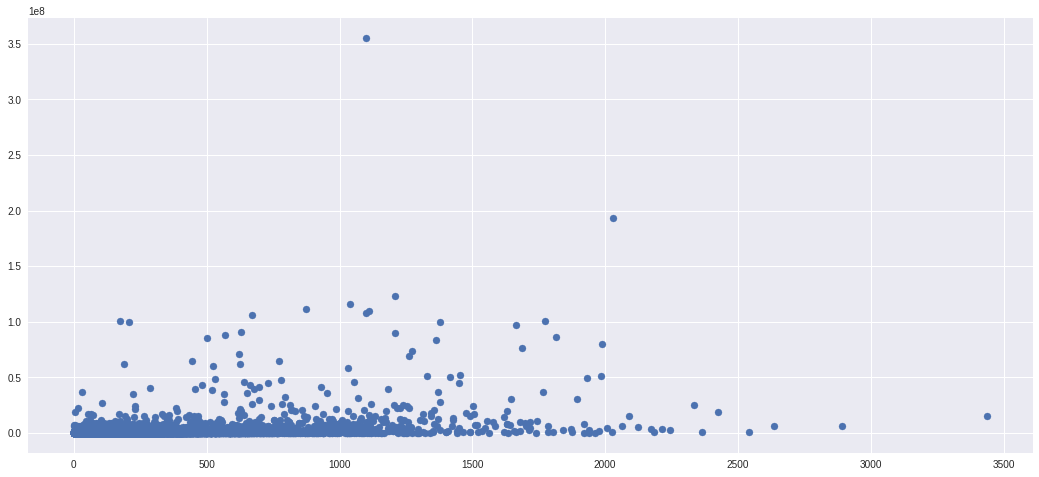

In [0]:
plt.scatter(claim_lengths, incurred_vals)

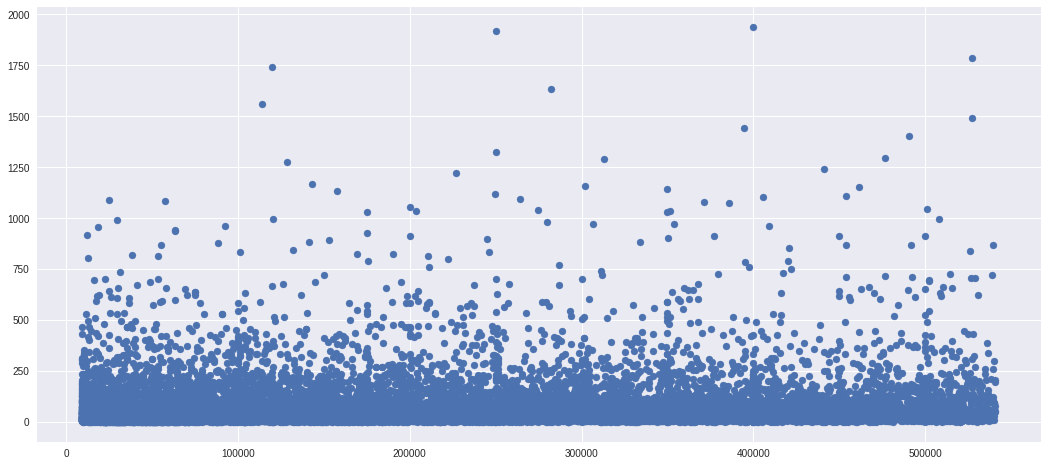

In [0]:
plt.scatter(incurred_filtered, lengths_filtered)